In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import requests
import numpy as np

In [2]:
class Replaybuffer:
    def __init__(self,n_state,n_action, batchsize):
        self.n_state = n_state
        self.n_action = n_action
        self.size = 2000 #记忆池大小
        self.batchsize = batchsize

        #给记忆五元组申请空间
        self.s = np.empty(shape = (self.size, self.n_state), dtype=np.float32)
        self.a = np.random.randint(low=0, high=n_action, size=self.size, dtype=np.uint8)
        self.r = np.empty(self.size, dtype=np.float32)
        self.done = np.random.randint(low=0, high=2, size=self.size, dtype=np.uint8)
        self.s_ = np.empty(shape = (self.size, self.n_state), dtype=np.float32)

        self.t = 0
        self.tmax = 0  # 初始化tmax属性 ##后加

    def add_memo(self,s,a,r,done,s_): #需要实现功能：1.交互后增加记忆 2.sample batch时取出记忆
    #第t步向记忆池里加记忆
        #print("s:", s.shape)  # 打印s的形状
        #print("Expected s shape:", (self.n_state,))
        self.s[self.t] = s
        self.a[self.t] = a
        self.r[self.t] = r
        self.done[self.t] = done
        self.s_[self.t] = s_
        self.t = self.t + 1 if self.t + 1 < self.size else 1 #t到2001时，重新从1开始加
        self.tmax = max(self.tmax, self.t +1)



    def sample(self):
    #采样逻辑：Buffer里的经验如果比batchsize多，那就sample;如果比batchsize少，那就有几个取几个
        '''if self.tmax > self.size:
            idxes = random.sample(range(0, self.tmax),self.size)
        else:
            idxes = random.sample(range(0, self.tmax))'''

        if self.tmax > self.batchsize:
           k = self.batchsize  # 如果缓冲区样本数大于等于批次大小，使用批次大小
        else:
           k = self.tmax  # 否则，使用缓冲区的实际样本数量

        idxes = random.sample(range(0, self.tmax), k)  # 使用确定的k值抽样

        batch_s = []
        batch_a = []
        batch_r = []
        batch_done = []
        batch_s_ = []

        for idx in idxes: #抽64个数据
            batch_s.append(self.s[idx])
            batch_a.append(self.a[idx])
            batch_r.append(self.r[idx])
            batch_done.append(self.done[idx])
            batch_s_.append(self.s_[idx])

        #把numpy转换成torch的tensor
        batch_s = torch.as_tensor(np.asarray(batch_s),dtype=torch.float32)
        batch_a = torch.as_tensor(np.asarray(batch_a),dtype=torch.int64).unsqueeze(-1) #升维：从(2)升到(2,1)
        batch_r = torch.as_tensor(np.asarray(batch_r),dtype=torch.float32).unsqueeze(-1)
        batch_done = torch.as_tensor(np.asarray(batch_done),dtype=torch.float32).unsqueeze(-1)
        batch_s_ = torch.as_tensor(np.asarray(batch_s_),dtype=torch.float32)

        return batch_s, batch_a, batch_r, batch_done, batch_s_

In [3]:
class Qnetwork(nn.Module):
      def __init__(self, n_input, n_output):
          super().__init__() #继承Module父类

          self.net = nn.Sequential(
              nn.Linear(in_features= n_input, out_features = 128),
              nn.ReLU(), #nn.Tanh(),
              nn.Linear(in_features= 128, out_features = n_output))

      def forward(self,x):
           return self.net(x) #前向传播

      def act(self,obs): #面对s，找到最大的Q值（因为神经网络输出的不只是最大Q值），输出对应的action
          obs_tensor = torch.as_tensor(obs, dtype=torch.float32)
          q_value = self(obs_tensor.unsqueeze(0)) #转化成行向量
          max_q_idx = torch.argmax(input=q_value)
          action = max_q_idx.detach().item() #最大Q值索引对应的action
          return action


class AgentwRB:
   def __init__(self, n_input, n_output,  batchsize, Gamma=0.97, learning_rate = 0.01):
            self.n_input = n_input
            self.n_output = n_output
            self.learning_rate = learning_rate
            self.Gamma = Gamma
            self.batchsize = batchsize
            self.memo = Replaybuffer(self.n_input, self.n_output, self.batchsize) #先实例化Agent，得到memo，Memo再实例化Replaybuffer

            #两个网络结构相同，可以用同一个类实例化
            self.online_net = Qnetwork(self.n_input, self.n_output)
            self.target_net = Qnetwork(self.n_input, self.n_output)

            self.optimizer = torch.optim.Adam(self.online_net.parameters(),lr=self.learning_rate)

In [4]:
##EPSILON START = 0.01

env = gym.make('CartPole-v1')
n_input = env.observation_space.shape[0]
n_output = env.action_space.n

epsilon_decay = 10000
epsilon_start = 0.01 #best value from tuning hyperparameters
epsilon_end = 0.01
n_step = 500
n_episode = 1000
TARGET_UPDATE = 10
Gamma=0.97
learning_rate = 0.01
s = env.reset()
agent = AgentwRB(n_input, n_output, 64)
episode_array = []
rewards_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end]) #插值
        #episode * n_step + step:当前第episode第step要插值的点
        #[0, EPSILON_DECAY]：数据点横坐标 [EPSILON_START, EPSILON_END]：数据点纵坐标
        #epsilon值会在EPSILON_DECAY之内从EPSILON_START线性变化到EPSILON_END

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode_array.append(episode)
        rewards_array.append(reward)





/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/

Episode:0
Reward:nan
Episode:10
Reward:9.7
Episode:20
Reward:9.4
Episode:30
Reward:9.4
Episode:40
Reward:9.1
Episode:50
Reward:9.7
Episode:60
Reward:9.5
Episode:70
Reward:9.1
Episode:80
Reward:8.8
Episode:90
Reward:8.8
Episode:100
Reward:9.7
Episode:110
Reward:9.7
Episode:120
Reward:10.3
Episode:130
Reward:9.4
Episode:140
Reward:9.8
Episode:150
Reward:9.1
Episode:160
Reward:9.8
Episode:170
Reward:9.8
Episode:180
Reward:9.2
Episode:190
Reward:9.7
Episode:200
Reward:9.1
Episode:210
Reward:9.6
Episode:220
Reward:10.0
Episode:230
Reward:9.6
Episode:240
Reward:9.4
Episode:250
Reward:9.7
Episode:260
Reward:8.9
Episode:270
Reward:9.1
Episode:280
Reward:9.4
Episode:290
Reward:9.4
Episode:300
Reward:9.7
Episode:310
Reward:9.3
Episode:320
Reward:9.3
Episode:330
Reward:9.9
Episode:340
Reward:9.7
Episode:350
Reward:9.5
Episode:360
Reward:9.5
Episode:370
Reward:9.4
Episode:380
Reward:9.7
Episode:390
Reward:9.3
Episode:400
Reward:9.2
Episode:410
Reward:9.5
Episode:420
Reward:9.8
Episode:430
Reward:9

In [5]:
##EPSILON START = 0.1

s = env.reset()
agent = AgentwRB(n_input, n_output, 64)
episode2_array = []
rewards2_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000
epsilon_start = 0.1

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode2_array.append(episode)
        rewards2_array.append(reward)


Episode:0
Reward:nan
Episode:10
Reward:9.4
Episode:20
Reward:9.5
Episode:30
Reward:10.2
Episode:40
Reward:9.8
Episode:50
Reward:9.4
Episode:60
Reward:10.3
Episode:70
Reward:9.5
Episode:80
Reward:9.4
Episode:90
Reward:9.5
Episode:100
Reward:9.9
Episode:110
Reward:9.4
Episode:120
Reward:9.5
Episode:130
Reward:9.7
Episode:140
Reward:9.8
Episode:150
Reward:9.2
Episode:160
Reward:9.7
Episode:170
Reward:10.0
Episode:180
Reward:10.0
Episode:190
Reward:9.0
Episode:200
Reward:9.1
Episode:210
Reward:10.3
Episode:220
Reward:9.8
Episode:230
Reward:9.4
Episode:240
Reward:10.2
Episode:250
Reward:9.3
Episode:260
Reward:9.7
Episode:270
Reward:10.0
Episode:280
Reward:9.4
Episode:290
Reward:9.7
Episode:300
Reward:9.3
Episode:310
Reward:9.7
Episode:320
Reward:9.6
Episode:330
Reward:9.8
Episode:340
Reward:9.4
Episode:350
Reward:9.8
Episode:360
Reward:9.9
Episode:370
Reward:9.6
Episode:380
Reward:9.1
Episode:390
Reward:9.9
Episode:400
Reward:9.5
Episode:410
Reward:9.6
Episode:420
Reward:9.2
Episode:430
Rew

In [6]:
##EPSILON START 0.5

s = env.reset()
agent = AgentwRB(n_input, n_output, 64)
episode3_array = []
rewards3_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000
epsilon_start = 0.5

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode3_array.append(episode)
        rewards3_array.append(reward)

Episode:0
Reward:nan
Episode:10
Reward:11.9
Episode:20
Reward:10.4
Episode:30
Reward:11.7
Episode:40
Reward:13.2
Episode:50
Reward:16.1
Episode:60
Reward:22.4
Episode:70
Reward:18.0
Episode:80
Reward:28.6
Episode:90
Reward:16.6
Episode:100
Reward:10.4
Episode:110
Reward:10.8
Episode:120
Reward:9.8
Episode:130
Reward:10.4
Episode:140
Reward:19.5
Episode:150
Reward:32.2
Episode:160
Reward:40.7
Episode:170
Reward:174.1
Episode:180
Reward:219.1
Episode:190
Reward:118.9
Episode:200
Reward:126.5
Episode:210
Reward:196.7
Episode:220
Reward:125.0
Episode:230
Reward:133.8
Episode:240
Reward:51.6
Episode:250
Reward:123.2
Episode:260
Reward:103.8
Episode:270
Reward:128.4
Episode:280
Reward:41.4
Episode:290
Reward:153.6
Episode:300
Reward:108.9
Episode:310
Reward:55.5
Episode:320
Reward:73.3
Episode:330
Reward:128.7
Episode:340
Reward:107.0
Episode:350
Reward:59.3
Episode:360
Reward:155.5
Episode:370
Reward:86.6
Episode:380
Reward:69.8
Episode:390
Reward:36.8
Episode:400
Reward:59.7
Episode:410
Re

In [7]:
##EPSILON START 0.8

s = env.reset()
agent = AgentwRB(n_input, n_output, 64)
episode4_array = []
rewards4_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000
epsilon_start = 0.8

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode4_array.append(episode)
        rewards4_array.append(reward)

Episode:0
Reward:nan
Episode:10
Reward:16.7
Episode:20
Reward:11.2
Episode:30
Reward:10.9
Episode:40
Reward:12.0
Episode:50
Reward:15.4
Episode:60
Reward:31.3
Episode:70
Reward:98.8
Episode:80
Reward:200.4
Episode:90
Reward:169.2
Episode:100
Reward:177.4
Episode:110
Reward:103.1
Episode:120
Reward:109.1
Episode:130
Reward:108.6
Episode:140
Reward:42.7
Episode:150
Reward:160.7
Episode:160
Reward:224.4
Episode:170
Reward:136.7
Episode:180
Reward:256.3
Episode:190
Reward:178.4
Episode:200
Reward:129.4
Episode:210
Reward:26.1
Episode:220
Reward:19.2
Episode:230
Reward:45.5
Episode:240
Reward:131.7
Episode:250
Reward:176.4
Episode:260
Reward:134.4
Episode:270
Reward:341.6
Episode:280
Reward:95.2
Episode:290
Reward:62.4
Episode:300
Reward:53.5
Episode:310
Reward:24.1
Episode:320
Reward:63.4
Episode:330
Reward:82.8
Episode:340
Reward:161.6
Episode:350
Reward:125.5
Episode:360
Reward:83.0
Episode:370
Reward:161.2
Episode:380
Reward:82.6
Episode:390
Reward:355.8
Episode:400
Reward:149.8
Episode

In [8]:
##EPSILON START 1.0

s = env.reset()
agent = AgentwRB(n_input, n_output, 64)
episode5_array = []
rewards5_array = []
Reward_list = np.empty(shape=n_episode)
n_episode = 1000
epsilon_start = 1.0

for episode in range(n_episode):
    epi_reward = 0
    for step in range(n_step):
        'epsilon greedy with decay of epsilon'
        epsilon = np.interp(episode * n_step + step, [0, epsilon_decay], [epsilon_start, epsilon_end])

        random_sample = random.random()
        if random_sample <= epsilon:
           a = env.action_space.sample()
        else:
           a = agent.online_net.act(s) #todo
        'Interact with the env'
        #print(env.step(a))

        s_, r, done, _ = env.step(a) #执行动作a，得到s_,r,done,info
        agent.memo.add_memo(s, a, r, done, s_) #添加经验到exp buffer里
        s = s_ #store transition
        epi_reward += r
        #print(epi_reward)

        if done:
           s = env.reset()
           Reward_list[episode] = epi_reward #记录这个episode的总奖励
           break

        '''Sample minibatches from the transition'''
        batch_s, batch_a, batch_r, batch_done, batch_s_ = agent.memo.sample()

        '''Compute Q_target'''
        target_q_values = agent.target_net(batch_s_)
        target_q = batch_r + agent.Gamma * (1-batch_done) * target_q_values.max(dim=1, keepdim=True)[0]
        '''Compute Q_pred'''
        pred_q_values = agent.online_net(batch_s) #对于批处理中的每个状态，它都会给出每个动作的Q值
        pred_q = torch.gather(input=pred_q_values, dim=1, index=batch_a)
        #跟据batch_a中指定的动作索引，从每个状态的动作Q值pred_q_values中选择对应动作的
        '''Compute Loss, gredient descent'''
        loss = nn.functional.smooth_l1_loss(target_q, pred_q)
        agent.optimizer.zero_grad()
        loss.backward()
        agent.optimizer.step() #根据梯度进行下降

        '''Fix Q-target'''
    if episode % TARGET_UPDATE ==0:
        agent.target_net.load_state_dict(agent.online_net.state_dict())
        reward = np.mean(Reward_list[episode-10:episode])
        print("Episode:{}".format(episode))
        print("Reward:{}".format(reward))
        episode5_array.append(episode)
        rewards5_array.append(reward)

Episode:0
Reward:nan
Episode:10
Reward:21.5
Episode:20
Reward:33.5
Episode:30
Reward:21.2
Episode:40
Reward:27.9
Episode:50
Reward:24.2
Episode:60
Reward:41.0
Episode:70
Reward:42.7
Episode:80
Reward:58.9
Episode:90
Reward:62.2
Episode:100
Reward:71.8
Episode:110
Reward:84.6
Episode:120
Reward:89.2
Episode:130
Reward:90.2
Episode:140
Reward:63.4
Episode:150
Reward:87.4
Episode:160
Reward:42.8
Episode:170
Reward:89.2
Episode:180
Reward:79.5
Episode:190
Reward:67.7
Episode:200
Reward:103.4
Episode:210
Reward:82.5
Episode:220
Reward:108.2
Episode:230
Reward:105.3
Episode:240
Reward:120.8
Episode:250
Reward:70.2
Episode:260
Reward:127.3
Episode:270
Reward:83.6
Episode:280
Reward:107.1
Episode:290
Reward:100.8
Episode:300
Reward:109.9
Episode:310
Reward:104.3
Episode:320
Reward:80.8
Episode:330
Reward:124.7
Episode:340
Reward:118.8
Episode:350
Reward:109.7
Episode:360
Reward:93.6
Episode:370
Reward:127.0
Episode:380
Reward:111.8
Episode:390
Reward:122.9
Episode:400
Reward:137.4
Episode:410


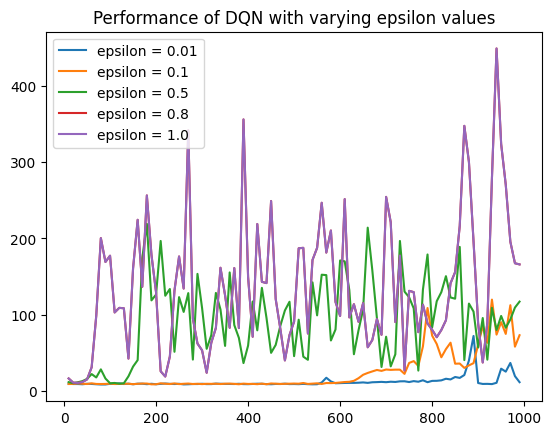

In [9]:
plt.title("Performance of DQN with varying epsilon values")
plt.plot(episode_array, rewards_array, label = "epsilon = 0.01")
plt.plot(episode2_array, rewards2_array, label = "epsilon = 0.1")
plt.plot(episode3_array, rewards3_array, label = "epsilon = 0.5")
plt.plot(episode4_array, rewards4_array, label = "epsilon = 0.8")
plt.plot(episode4_array, rewards4_array, label = "epsilon = 1.0")

plt.legend()
plt.show()